Disclaimer: Some naming convention are not pythonic. I try to use the same names as in the paper.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import joblib
import os
from tqdm import tqdm
from sklearn.metrics import r2_score

In [2]:
columns = ["b/m", "de", "dfr", "dfy", "dp", "dy", "ep", "infl", "ltr", "lty", "ntis", "svar", "tbl", "tms", "lag_returns"]

data_raw = pd.read_csv("data/PredictorData2021 - Monthly.csv")
data_raw["yyyymm"] = pd.to_datetime(data_raw["yyyymm"], format='%Y%m', errors='coerce')
data_raw["Index"] = data_raw["Index"].str.replace(",", "")
data_raw = data_raw.set_index("yyyymm")
data_raw[data_raw.columns] = data_raw[data_raw.columns].astype(float)
data_raw = data_raw.rename({"Index":"prices"}, axis=1)

# Calculate missing columns
data_raw["dfy"] = data_raw["BAA"] - data_raw["AAA"]
data_raw["tms"] = data_raw["lty"] - data_raw["tbl"]
data_raw["de"] = np.log(data_raw["D12"]) - np.log(data_raw["E12"])
data_raw["dfr"] = data_raw["corpr"] - data_raw["ltr"]
data_raw["lag_price"] = data_raw["prices"].shift()
data_raw["dp"] = np.log(data_raw["D12"]) - np.log(data_raw["prices"])
data_raw["dy"] = np.log(data_raw["D12"]) - np.log(data_raw["lag_price"])
data_raw["ep"] = np.log(data_raw["E12"])  - np.log(data_raw["prices"])

data_raw["returns"] = data_raw["prices"].pct_change()
data_raw["lag_returns"] = data_raw["returns"].shift()

returns = data_raw["returns"].copy()
prices = data_raw["prices"].copy()

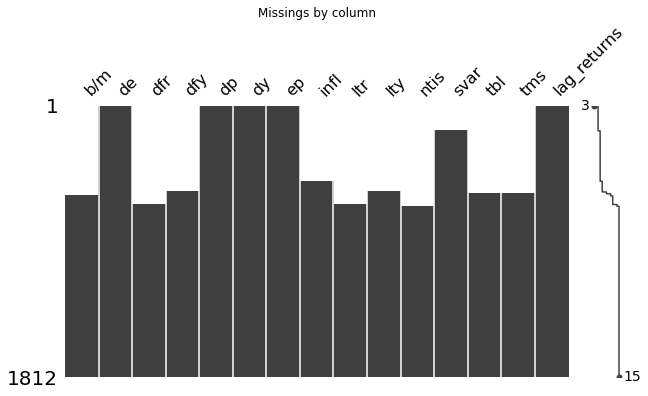

In [3]:
msno.matrix(data_raw[columns], figsize=(10,5))
plt.title("Missings by column")
plt.savefig("plots/missing_pattern.jpg")
data = data_raw[columns].dropna()
returns = returns[returns.index.isin(data.index)]

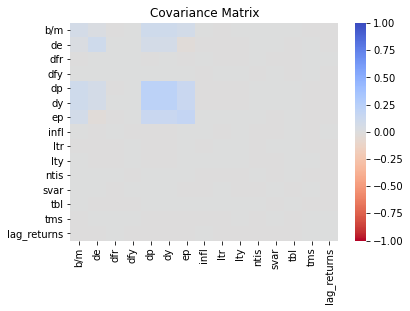

In [4]:
sns.heatmap(data[columns].cov(), center=0, vmin=-1, vmax=1, cmap=sns.color_palette("coolwarm_r", as_cmap=True))
fig = plt.gcf()
fig.figsize = (10,10)
plt.title("Covariance Matrix")
plt.savefig("plots/covariance.jpg")

# Random Fourier Features

In [5]:
data = data[columns].copy()

if "omegas.joblib" not in os.listdir("data"):
    print("Calculating omegas.")
    omegas = []
    for i in tqdm(range(6000)): # 6000*2 = 12000 = P
        omega = np.random.normal(0, 2, len(columns))
        data[f"sin_{i}"] = np.sin(data[columns] @ omega)
        data[f"cos_{i}"] = np.cos(data[columns] @ omega)
        omegas.append(omega)
    joblib.dump(omegas, "data/omegas.joblib")
    data.to_parquet("data/data.parquet")

else:
    omegas = joblib.load("data/omegas.joblib")
    data = pd.read_parquet("data/data.parquet")
    print("data & omegas.joblib loaded.")

print("Shape of data after generating RFFs:", data.shape)

data & omegas.joblib loaded.
Shape of data after generating RFFs: (1141, 12015)


# Model

In [6]:
%%time
z_values = [10**-3, 10**3]
t_values = list(range(12, data.shape[0]))

if "backtest_progress.joblib" in os.listdir("data"):
    backtest = joblib.load("data/backtest_progress.joblib")
    done_values = [item["t"] + item["z"] for item in backtest]
else:
    backtest = []
    done_values = []
for z in z_values:
    for i, t in enumerate(tqdm(t_values[:-1])):
        if (t+z) in done_values:
            continue # Continue progress
        R = returns[i+1:t+1].values         # y_train
        R_s = returns[t+1:t+2].values       # y_test
        R_s_index = returns[t+1:t+2].index  # y_test
        S = data[i:t]                       # X_train
        S_t = data[t:t+1]                   # X_test
        T, nr_cols = S.shape

        # Ridge Regression with Moore-Penrose pseudo-inverse
        beta = np.linalg.pinv(z*np.identity(nr_cols) +  (S.T @ S)/T) @ (R @ S)/T
        beta_norm = np.sqrt((beta**2).sum())

        forecast = S_t @ beta
        timing_strategy = forecast * R_s

        backtest.append({"z":z, "t":t, "beta_norm":beta_norm, 
            "index":forecast.index[0], "forecast":forecast.values[0], 
            "timing_strategy_index":R_s_index[0], "timing_strategy":timing_strategy.values[0], "return":R_s[0]
        })
        joblib.dump(backtest, "data/backtest_progress.joblib")
    print(f"Done z={z}")
backtest = pd.DataFrame(backtest)
backtest.to_parquet("data/backtest.parquet")

  0%|          | 0/1128 [00:00<?, ?it/s]

In [ ]:
def compounding_return(returns, start_val=100):
    return start_val * (1 + returns).cumprod()

result = []
for z in z_values:
    df = backtest[backtest["z"] == z]
    result.append({
        "beta_norm_mean" : df["beta_norm"].mean(),
        "forecast_mean" : df["forecast"].mean(),
        "forecast_var" : df["forecast"].std(),
        "R2" : r2_score(df["forecast"], df["return"]),
        "SharpeRatio" : (compounding_return(df["forecast"]) - compounding_return(df["return"])).iloc[-1]/df["forecast"].std()
    })
    break
result = pd.DataFrame(result)

<AxesSubplot:>

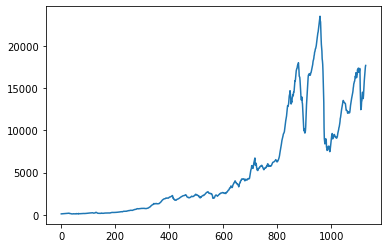

In [ ]:
compounding_return(df["forecast"]).plot()

<AxesSubplot:>

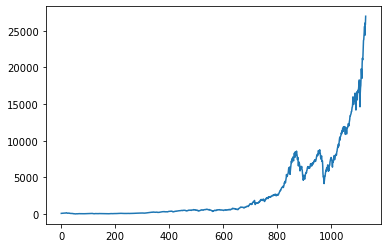

In [ ]:
compounding_return(df["return"]).plot()

In [ ]:
prices

yyyymm
1926-12-01      13.49
1927-01-01      13.21
1927-02-01      13.84
1927-03-01      13.93
1927-04-01      14.17
               ...   
2021-08-01    4522.68
2021-09-01    4307.54
2021-10-01    4605.38
2021-11-01    4567.00
2021-12-01    4766.18
Name: prices, Length: 1141, dtype: float64

<AxesSubplot:xlabel='yyyymm'>

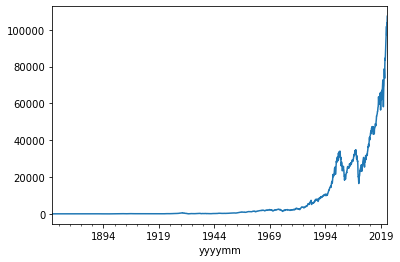

In [ ]:
compounding_return(returns).plot()

<AxesSubplot:xlabel='yyyymm'>

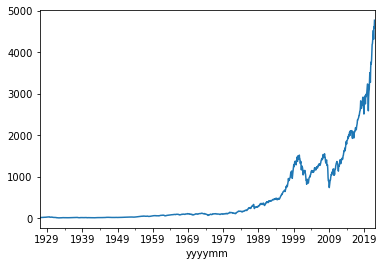

In [ ]:
prices.plot()

<AxesSubplot:>

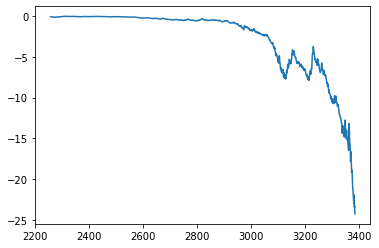

In [ ]:
def compounding_return(returns, start_val):
    return start_val * (1 + returns).cumprod()

In [ ]:
prices

yyyymm
1926-12-01      13.49
1927-01-01      13.21
1927-02-01      13.84
1927-03-01      13.93
1927-04-01      14.17
               ...   
2021-08-01    4522.68
2021-09-01    4307.54
2021-10-01    4605.38
2021-11-01    4567.00
2021-12-01    4766.18
Name: prices, Length: 1141, dtype: float64

In [ ]:
prices[-1128:]

yyyymm
1928-01-01      17.57
1928-02-01      17.26
1928-03-01      19.13
1928-04-01      19.75
1928-05-01      20.00
               ...   
2021-08-01    4522.68
2021-09-01    4307.54
2021-10-01    4605.38
2021-11-01    4567.00
2021-12-01    4766.18
Name: prices, Length: 1128, dtype: float64